In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


The dataset was downloaded and converted into two NumPy files in a separate notebook (not included in the final submission). The NumPy files 'data120.npy' and 'labels120.npy' were then uploaded to the assignment's file directory. To run the code below, it is necessary to rename the file directory accordingly and ensure that the data files have names identical to the ones used here.

The assingment submission includes two working files. In the first file, the fine-tuning of the CNN model was performed. In the second file, an optimal transfer learning model is established. In this notebook, only the final models of the two files are presented.

# Call data from directory

In [ ]:
import os
import ipython_config
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
import tensorflow as tf
import textwrap
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from tensorflow import keras
from tensorflow.keras import layers, models, regularizers, utils
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam

utils.set_random_seed(42)

file_dir = ipython_config.FILE_DIR
data = np.load(file_dir + "data120.npy")
labels = np.load(file_dir + "labels120.npy", allow_pickle=True)
print(labels)

['Lung adenocarcinoma' 'Lung adenocarcinoma' 'Lung adenocarcinoma' ...
 'Colon adenocarcinoma' 'Colon adenocarcinoma' 'Colon adenocarcinoma']


# Preprocessing and EDA (Exploratory Data Analysis)


## Converting the Target Values to the One-Hot-Encoded Format

In [ ]:
# Show information on data dimensions and labels
classes, class_indices = np.unique(labels, return_index=True)
n_classes=len(classes)

print(f'num of classes: {n_classes}')
print(f'class labels: {classes}')
print()
print(f'data dimensions: {data.shape}')
print(f'labels dimensions: {labels.shape}')

num of classes: 5
class labels: ['Colon Benign Tissue' 'Colon adenocarcinoma' 'Lung Benign Tissue'
 'Lung Squamous Cell Carcinoma' 'Lung adenocarcinoma']

data dimensions: (25000, 120, 120, 3)
labels dimensions: (25000,)


In [ ]:
# Initialize OneHotEncoder
encoder = OneHotEncoder(dtype=int)

# Fit and transform the labels
y = encoder.fit_transform(labels.reshape(-1, 1))

# Convert the encoded labels to numpy array
y = y.toarray()

print(y)

[[0 0 0 0 1]
 [0 0 0 0 1]
 [0 0 0 0 1]
 ...
 [0 1 0 0 0]
 [0 1 0 0 0]
 [0 1 0 0 0]]


In [ ]:
# Display each class with its corresponding encoding
for index, label in zip(class_indices, classes):
    encoded_label = y[index]
    print(f"{label}: {encoded_label}")

Colon Benign Tissue: [1 0 0 0 0]
Colon adenocarcinoma: [0 1 0 0 0]
Lung Benign Tissue: [0 0 1 0 0]
Lung Squamous Cell Carcinoma: [0 0 0 1 0]
Lung adenocarcinoma: [0 0 0 0 1]


## Visualizing Sample Images

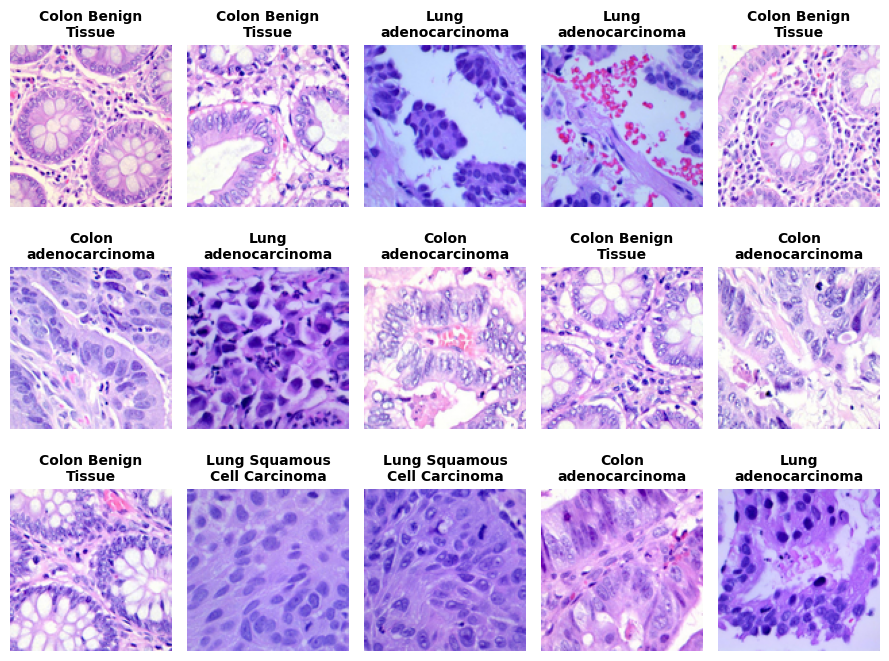

In [ ]:
# Randomly sample 15 indices of the data array
sample15 = np.random.permutation(len(data))[:15]

# Create a figure
plt.figure(figsize=(9, 7))

# Iterate over the sample and create subplots with images and titles
for i in range(15):
    plt.subplot(3, 5, i + 1)

    # Get the index from the selected sample
    index = sample15[i]

    # Scale data to range (0 - 1)
    image = data[index] / 255
    plt.imshow(image)

    # Get the label of the image and wrap it in multiple lines if needed
    # Source: https://stackoverflow.com/questions/3464359/is-it-possible-to-wrap-the-text-of-xticks-in-matplotlib-in-python
    label = labels[index]
    label = '\n'.join(textwrap.wrap(label, width=15))

    # Set title
    plt.title(label, fontsize=10, fontweight='bold')
    plt.axis('off')

plt.tight_layout()
plt.show()

## Visualizing Class Distribution

('Colon Benign Tissue', 5000)
('Colon adenocarcinoma', 5000)
('Lung Benign Tissue', 5000)
('Lung Squamous Cell Carcinoma', 5000)
('Lung adenocarcinoma', 5000)


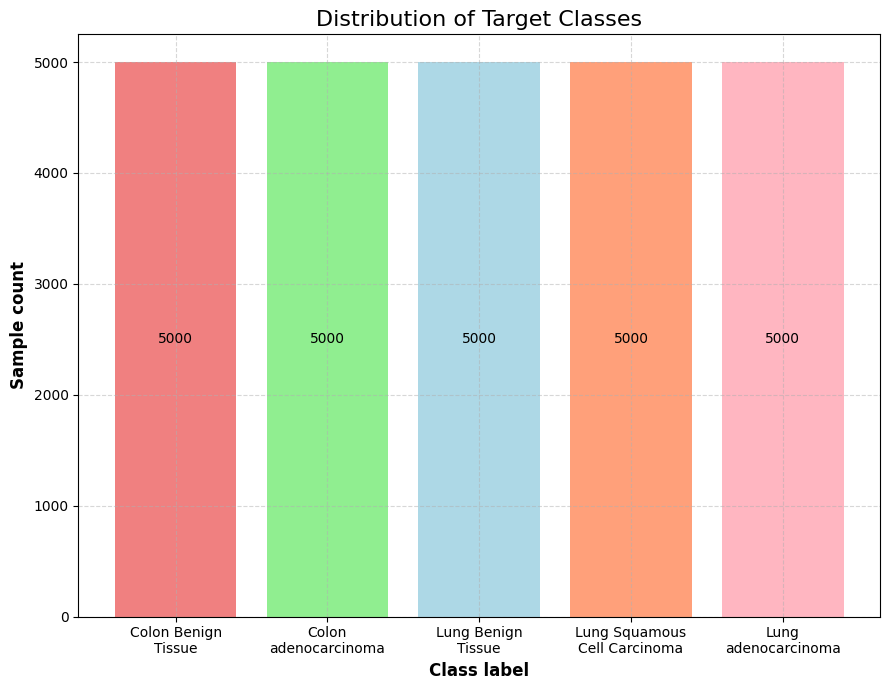

In [ ]:
# Count occurrences of each class label
unique_labels, label_counts = np.unique(labels, return_counts=True)
for i in zip(unique_labels, label_counts):
  print(i)

# Define colors for the bar plot
colors = ['lightcoral', 'lightgreen', 'lightblue', 'lightsalmon', 'lightpink']

# Plot the bar plot
plt.figure(figsize=(9, 7))
bars = plt.bar(unique_labels, label_counts, color=colors)

# Add value annotations on each bar
for bar, count in zip(bars, label_counts):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() / 2, str(count),
             ha='center', va='center', color='black', fontsize=10)

# Wrap the labels on the x-axis
# Source: https://stackoverflow.com/questions/3464359/is-it-possible-to-wrap-the-text-of-xticks-in-matplotlib-in-python
wrapped_labels = [textwrap.fill(label, width=15) for label in unique_labels]
plt.xticks(unique_labels, wrapped_labels, ha='center')

# Add title and labels with styling
plt.title('Distribution of Target Classes', fontsize=16)
plt.xlabel('Class label', fontweight='bold', fontsize=12)
plt.ylabel('Sample count', fontweight='bold', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

##Train-Test-Val Split

In [ ]:
# Perform train-test split for train and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.20,
                                                    random_state=42, stratify=y)

# Perform train-test split for train and validation sets (75% train, 25% validation)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25,
                                                  random_state=42, stratify=y_train)

# Print the shapes of the resulting sets
print("Train set shape (X and y):", X_train.shape, y_train.shape)
print("Validation set shape (X and y):", X_val.shape, y_val.shape)
print("Test set shape (X and y):", X_test.shape, y_test.shape)

Train set shape (X and y): (15000, 120, 120, 3) (15000, 5)
Validation set shape (X and y): (5000, 120, 120, 3) (5000, 5)
Test set shape (X and y): (5000, 120, 120, 3) (5000, 5)


In [ ]:
# Save dataset splits for later (model tuning)
with open('datasets.pkl', 'wb') as f:
    pickle.dump((X_train, y_train, X_val, y_val, X_test, y_test), f)

# Evaluation Functions

In [ ]:
# Loss and accuracy plots over epochs

# Function created in part with the help of Ibrahim, 2023:
# https://www.kaggle.com/code/abdallahwagih/lung-colon-cancer-cnn-98-6

def plot_history(history, model_name):
    # Define relevant metrics
    tr_acc = history.history['accuracy']
    tr_loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']
    epochs = range(1, len(tr_acc) + 1)

    # Define plot style
    plt.figure(figsize= (22, 8))
    plt.style.use('ggplot')

    # Plot training and validation accuracies
    plt.subplot(1, 2, 1)
    epochs = range(1, len(tr_acc) + 1)  # Adjust epochs to start from 1
    plt.plot(epochs, tr_acc, label='Training Accuracy', lw=4, c='firebrick')
    plt.plot(epochs, val_acc, label='Validation Accuracy', lw=4, c='darkgreen')
    best_epoch_acc = np.argmax(val_acc)+1
    plt.scatter(best_epoch_acc, max(val_acc), c='mediumblue',
                s=100, label=f'Best epoch = {best_epoch_acc}')
    plt.xlabel('Epochs', fontsize=18)
    plt.ylabel('Accuracy', fontsize=18)
    plt.title(f'{model_name} Training and Validation Accuracy', fontsize=18, fontweight='bold')
    plt.legend(fontsize=15)
    plt.grid(True)

    # Plot training and validation losses
    plt.subplot(1, 2, 2)
    plt.plot(epochs, tr_loss, label='Training Loss', lw=4, c='firebrick')
    plt.plot(epochs, val_loss, label='Validation Loss', lw=4, c='darkgreen')
    best_epoch_loss = np.argmin(val_loss)+1
    plt.scatter(best_epoch_loss, min(val_loss), c='mediumblue',
                s=100, label=f'Best epoch = {best_epoch_loss}')
    plt.xlabel('Epochs', fontsize=18)
    plt.ylabel('Loss', fontsize=18)
    plt.title(f'{model_name} Training and Validation Loss', fontsize=18, fontweight='bold')
    plt.legend(fontsize=15)
    plt.grid(True)

    plt.tight_layout()
    plt.subplots_adjust(wspace=0.125)
    plt.show()

In [ ]:
# Display classification report and confusion matrix

def plot_cm(model, X, y, dataset_name, classes=classes):
    from sklearn.metrics import confusion_matrix, classification_report
    n_classes = len(classes)

    # Predict classes
    y_pred = np.argmax(model.predict(X, verbose=0), axis=1)

    # Convert one-hot encoded y to class labels
    y_true = np.argmax(y, axis=1)

    # Print classification report
    print(f'Classification report of the {dataset_name} set:')
    print(classification_report(y_true, y_pred, target_names=classes))

    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d',
                cmap=sns.cubehelix_palette(as_cmap=True),
                xticklabels=np.arange(n_classes), yticklabels=classes)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title(f'Confusion Matrix - {dataset_name} set')
    plt.show()
    print()

In [ ]:
# ROC curves

# Function created with the help of the source provided in the assignment instructions

def plot_roc(model, X, y, dataset_name, classes=classes):
    from sklearn.metrics import roc_curve, auc
    from sklearn.preprocessing import LabelBinarizer

    n_classes = len(classes)

    # Binarize the target by one-hot-encoding in a OvR fashion
    label_binarizer = LabelBinarizer().fit(y_train)
    y_true = label_binarizer.transform(y)

    # Predict classes
    y_pred = model.predict(X, verbose=0)

    # Compute ROC curve and ROC area for each class
    fpr, tpr, roc_auc = dict(), dict(), dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC and AUC
    fpr_micro, tpr_micro, _ = roc_curve(y_true.ravel(), y_pred.ravel())
    roc_auc_micro = auc(fpr_micro, tpr_micro)

    # Compute macro-average ROC and AUC
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)

    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    mean_tpr /= n_classes
    fpr_macro = all_fpr
    tpr_macro = mean_tpr
    roc_auc_macro = auc(fpr_macro, tpr_macro)

    # Plot ROC curves
    plt.figure(figsize=(8, 6))

    plt.plot(fpr_micro, tpr_micro,
             label=f'Micro-average ROC (area = {roc_auc_micro:.2f})',
             c='deeppink', ls=':', lw=4)

    plt.plot(fpr_macro, tpr_macro,
             label=f'Macro-average ROC (area = {roc_auc_macro:.2f})',
             c='navy', ls=':', lw=4)

    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label=f'ROC curve (class {i}) (area = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Multiclass Receiver Operating Characteristic - {dataset_name} set')
    plt.legend(loc="lower right")
    plt.show()


# Baseline Model

### Compile the model

In [ ]:
# Define the baseline model
def baseline(n_classes=5, input_shape=X_train.shape[1:]):
    model = models.Sequential()
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same',
                            input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(n_classes, activation='softmax'))
    return model

# Instantiate the model
model1 = baseline()

# Compile the model
model1.compile(optimizer='adam',
              metrics=['accuracy'],
              loss='categorical_crossentropy')

model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 120, 120, 128)     3584      
                                                                 
 max_pooling2d (MaxPooling2  (None, 60, 60, 128)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 64)        73792     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 57600)             0         
                                                                 
 dense (Dense)               (None, 128)               7

### Model training and evaluation

In [ ]:
# Train the model
history = model1.fit(X_train, y_train,
                    epochs=10, batch_size=32,
                    validation_data=(X_val, y_val), verbose=1)

# Evaluate the model on the test set
test_loss, test_accuracy = model1.evaluate(X_test, y_test)

print("Baseline test loss:", test_loss)
print("Baseline test accuracy:", test_accuracy)

Epoch 1/10
469/469 [==============================] - 27s 40ms/step - loss: 5.4930 - accuracy: 0.5859 - val_loss: 0.8385 - val_accuracy: 0.6446
Epoch 2/10
469/469 [==============================] - 16s 33ms/step - loss: 0.6027 - accuracy: 0.7100 - val_loss: 0.5350 - val_accuracy: 0.7384
Epoch 3/10
469/469 [==============================] - 16s 33ms/step - loss: 0.5281 - accuracy: 0.7440 - val_loss: 0.6256 - val_accuracy: 0.7342
Epoch 4/10
469/469 [==============================] - 15s 33ms/step - loss: 0.4874 - accuracy: 0.7710 - val_loss: 0.5788 - val_accuracy: 0.7508
Epoch 5/10
469/469 [==============================] - 15s 33ms/step - loss: 0.4729 - accuracy: 0.7747 - val_loss: 0.6251 - val_accuracy: 0.7444
Epoch 6/10
469/469 [==============================] - 17s 36ms/step - loss: 0.4395 - accuracy: 0.7931 - val_loss: 0.5759 - val_accuracy: 0.7568
Epoch 7/10
469/469 [==============================] - 16s 33ms/step - loss: 0.7677 - accuracy: 0.6697 - val_loss: 0.6818 - val_accuracy:

## Visualization

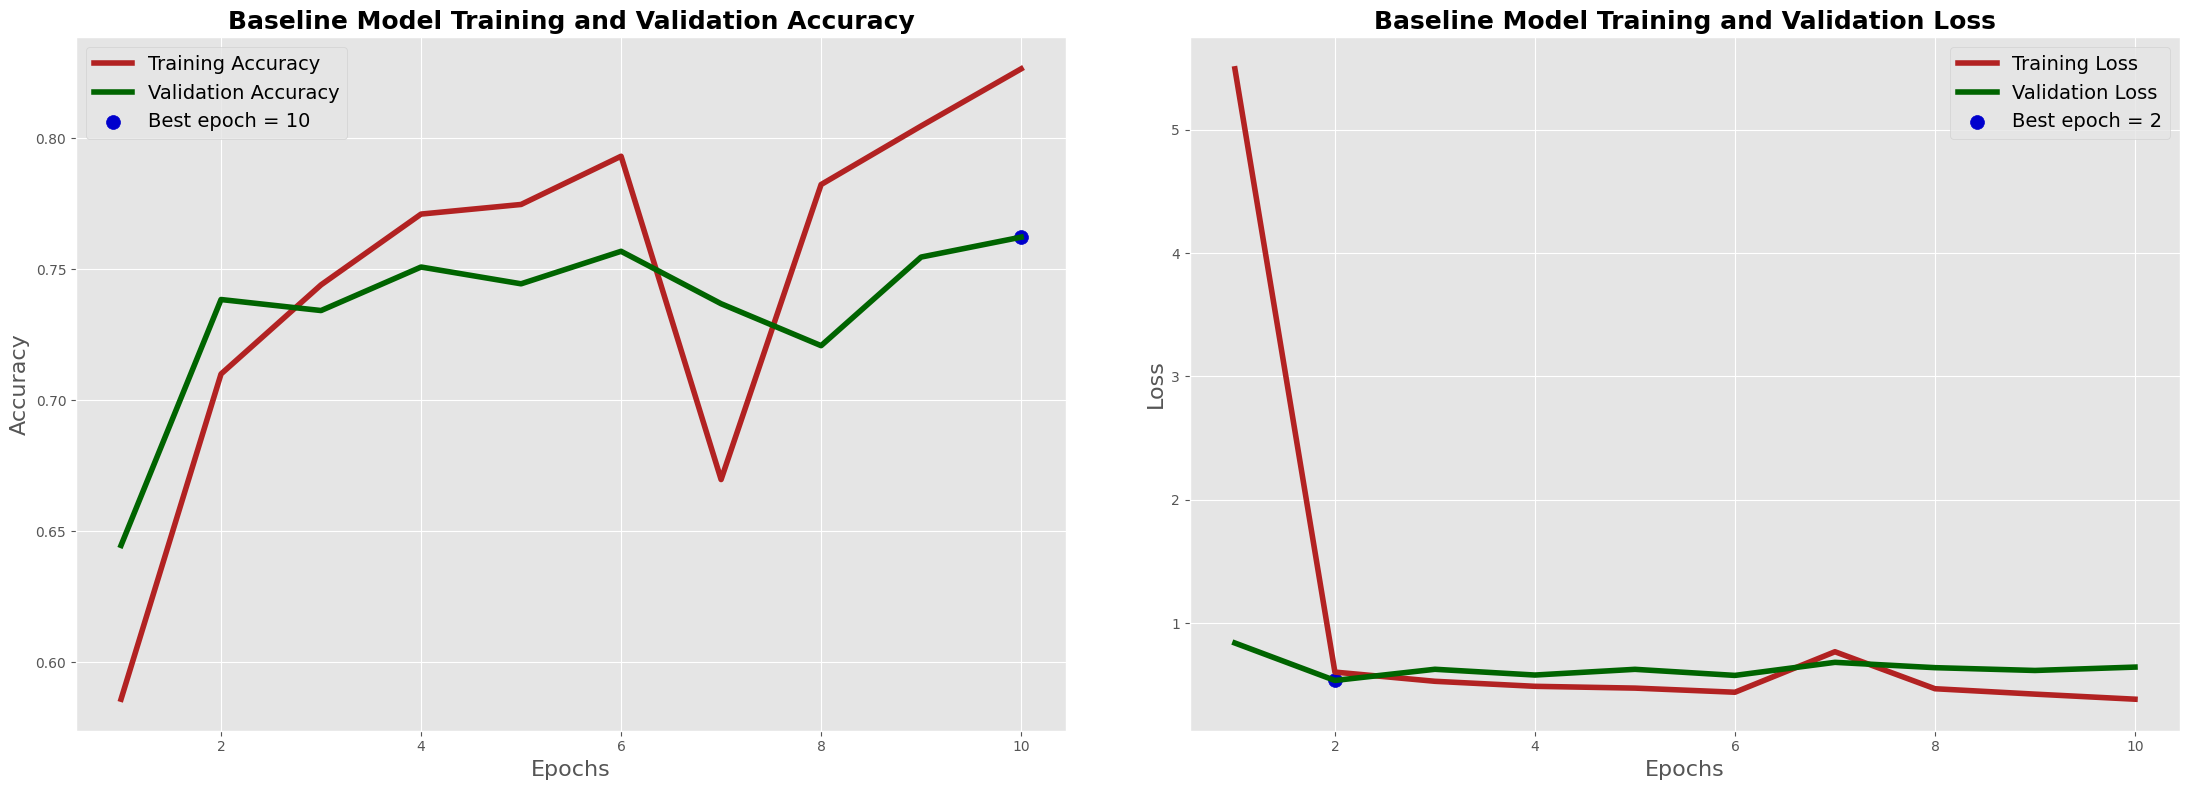

In [ ]:
plot_history(history, 'Baseline Model')

157/157 [==============================] - 177s 1s/step


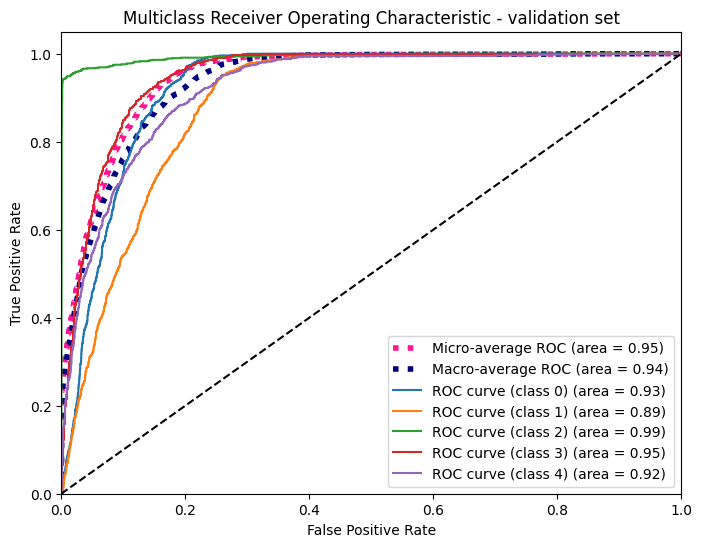

157/157 [==============================] - 111s 705ms/step


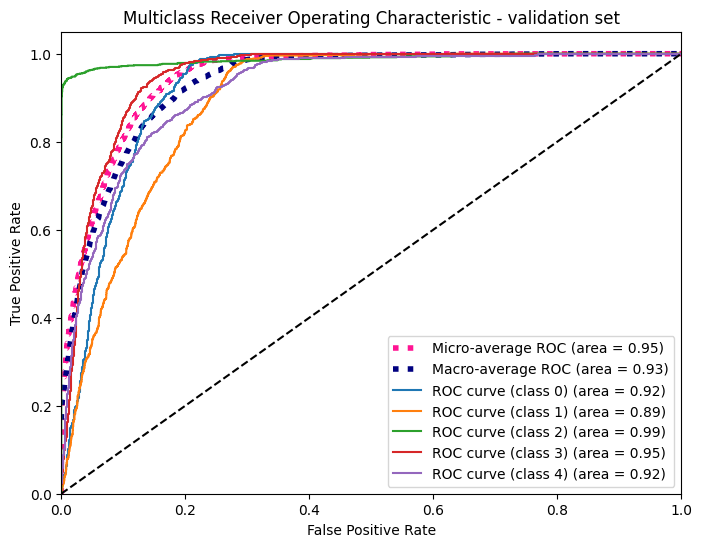

In [ ]:
# The output of the ROC plots here slightly differs from the ones displayed
# later on in the notebook. The plots here were created before some stylistical
# changes to the plot_roc function's output.
# The mistake in the title of the second plot has been addressed in the report.

plot_roc(model1, X_val, y_val, 'validation')
plot_roc(model1, X_test, y_test, 'test')

Classification report of the validation set:
                              precision    recall  f1-score   support

         Colon Benign Tissue       0.67      0.55      0.61      1000
        Colon adenocarcinoma       0.57      0.64      0.61      1000
          Lung Benign Tissue       0.99      0.94      0.96      1000
Lung Squamous Cell Carcinoma       0.68      0.81      0.74      1000
         Lung adenocarcinoma       0.68      0.61      0.65      1000

                    accuracy                           0.71      5000
                   macro avg       0.72      0.71      0.71      5000
                weighted avg       0.72      0.71      0.71      5000



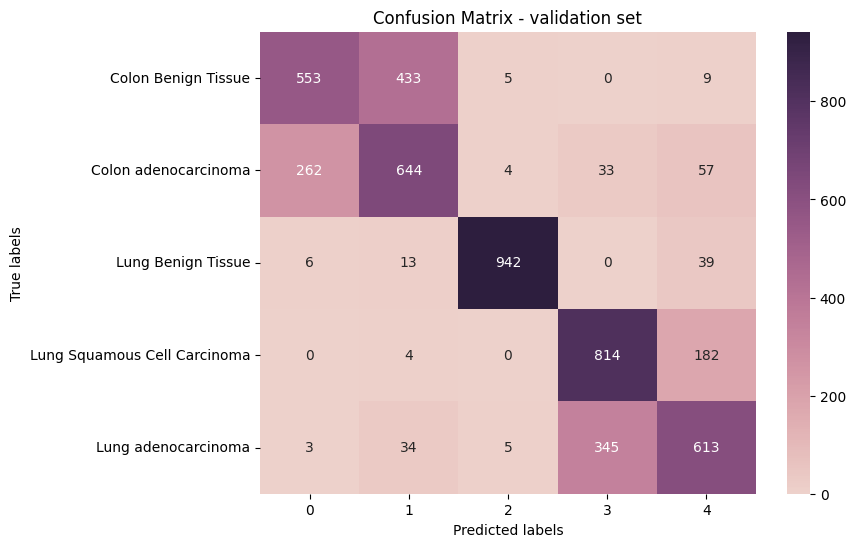


Classification report of the test set:
                              precision    recall  f1-score   support

         Colon Benign Tissue       0.65      0.56      0.60      1000
        Colon adenocarcinoma       0.58      0.64      0.61      1000
          Lung Benign Tissue       0.98      0.93      0.96      1000
Lung Squamous Cell Carcinoma       0.67      0.83      0.74      1000
         Lung adenocarcinoma       0.69      0.59      0.63      1000

                    accuracy                           0.71      5000
                   macro avg       0.72      0.71      0.71      5000
                weighted avg       0.72      0.71      0.71      5000



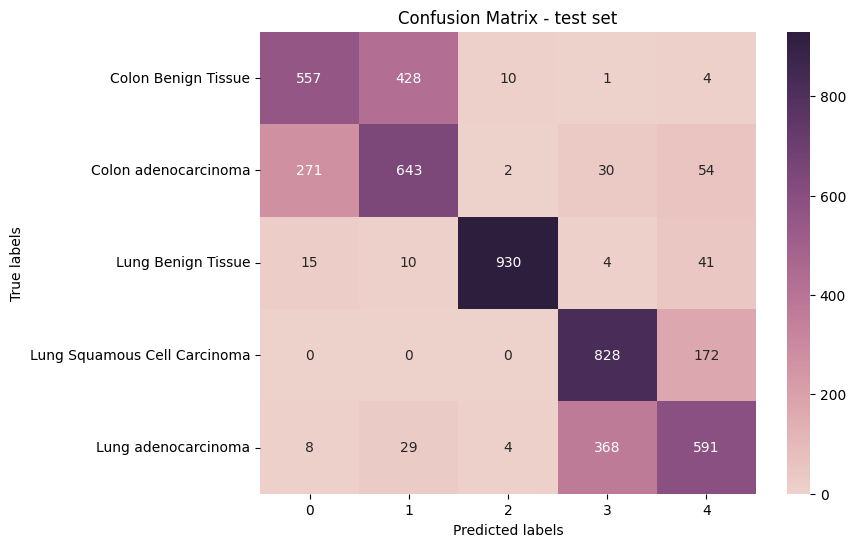

In [ ]:
plot_cm(model1, X_val, y_val, 'validation')
plot_cm(model1, X_test, y_test, 'test')

In [ ]:
# Save the results of the baseline model
results = {'history': history.history, 'test_loss': test_loss,
           'test_accuracy': test_accuracy}

with open(file_dir + 'Results/model1.pkl', 'wb') as file:
  pickle.dump(results, file)

# Enhanced Model

### Compile the model

In [ ]:
# Enhanced CNN model
# This is a final version of the improved model. Model tuning was performed in
# the enhanced_model_Jakob_Tjurlik.ipynb notebook

def tuned_model(regularizer=regularizers.l2(0.00001), n_classes=n_classes,
                input_shape=X_train.shape[1:]):
    model = models.Sequential()
    model.add(layers.Conv2D(32, (5, 5), strides=(2, 2), padding='same',
                            input_shape=input_shape, activation='relu',
                            kernel_regularizer=regularizer))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu',
                            kernel_regularizer=regularizer))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu',
                            kernel_regularizer=regularizer))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(256, (3, 3), padding='same', activation='relu',
                            kernel_regularizer=regularizer))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu', kernel_regularizer=regularizer))
    model.add(layers.Dense(32, activation='relu', kernel_regularizer=regularizer))
    model.add(layers.Dense(n_classes, activation='softmax'))

    return model

model = tuned_model()

# Compile the model
model.compile(optimizer='adam', metrics=['accuracy'],
              loss='categorical_crossentropy')

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 60, 60, 32)        2432      
                                                                 
 max_pooling2d (MaxPooling2  (None, 30, 30, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 30, 30, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 15, 15, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 15, 15, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 7, 7, 128)         0

### Model training and evaluation

In [ ]:
# Train the model
history = model.fit(X_train, y_train,
                             epochs=20,
                             batch_size=128,
                             validation_data=(X_val, y_val),
                             verbose=1)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)

print("Baseline test loss:", test_loss)
print("Baseline test accuracy:", test_accuracy)

Epoch 1/20
118/118 [==============================] - 18s 55ms/step - loss: 2.3666 - accuracy: 0.6323 - val_loss: 0.4378 - val_accuracy: 0.8152
Epoch 2/20
118/118 [==============================] - 3s 30ms/step - loss: 0.4371 - accuracy: 0.8161 - val_loss: 0.3875 - val_accuracy: 0.8366
Epoch 3/20
118/118 [==============================] - 3s 22ms/step - loss: 0.3130 - accuracy: 0.8740 - val_loss: 0.2679 - val_accuracy: 0.8920
Epoch 4/20
118/118 [==============================] - 3s 22ms/step - loss: 0.2558 - accuracy: 0.9010 - val_loss: 0.2116 - val_accuracy: 0.9244
Epoch 5/20
118/118 [==============================] - 3s 21ms/step - loss: 0.1778 - accuracy: 0.9339 - val_loss: 0.4107 - val_accuracy: 0.8424
Epoch 6/20
118/118 [==============================] - 3s 26ms/step - loss: 0.1969 - accuracy: 0.9256 - val_loss: 0.1822 - val_accuracy: 0.9312
Epoch 7/20
118/118 [==============================] - 3s 22ms/step - loss: 0.1302 - accuracy: 0.9520 - val_loss: 0.1309 - val_accuracy: 0.952

In [ ]:
# Save the results of the enhanced model
results = {'history': history.history, 'test_loss': test_loss,
           'test_accuracy': test_accuracy}

with open(file_dir + 'Results/enhanced_model.pkl', 'wb') as file:
  pickle.dump(results, file)

### Visualization

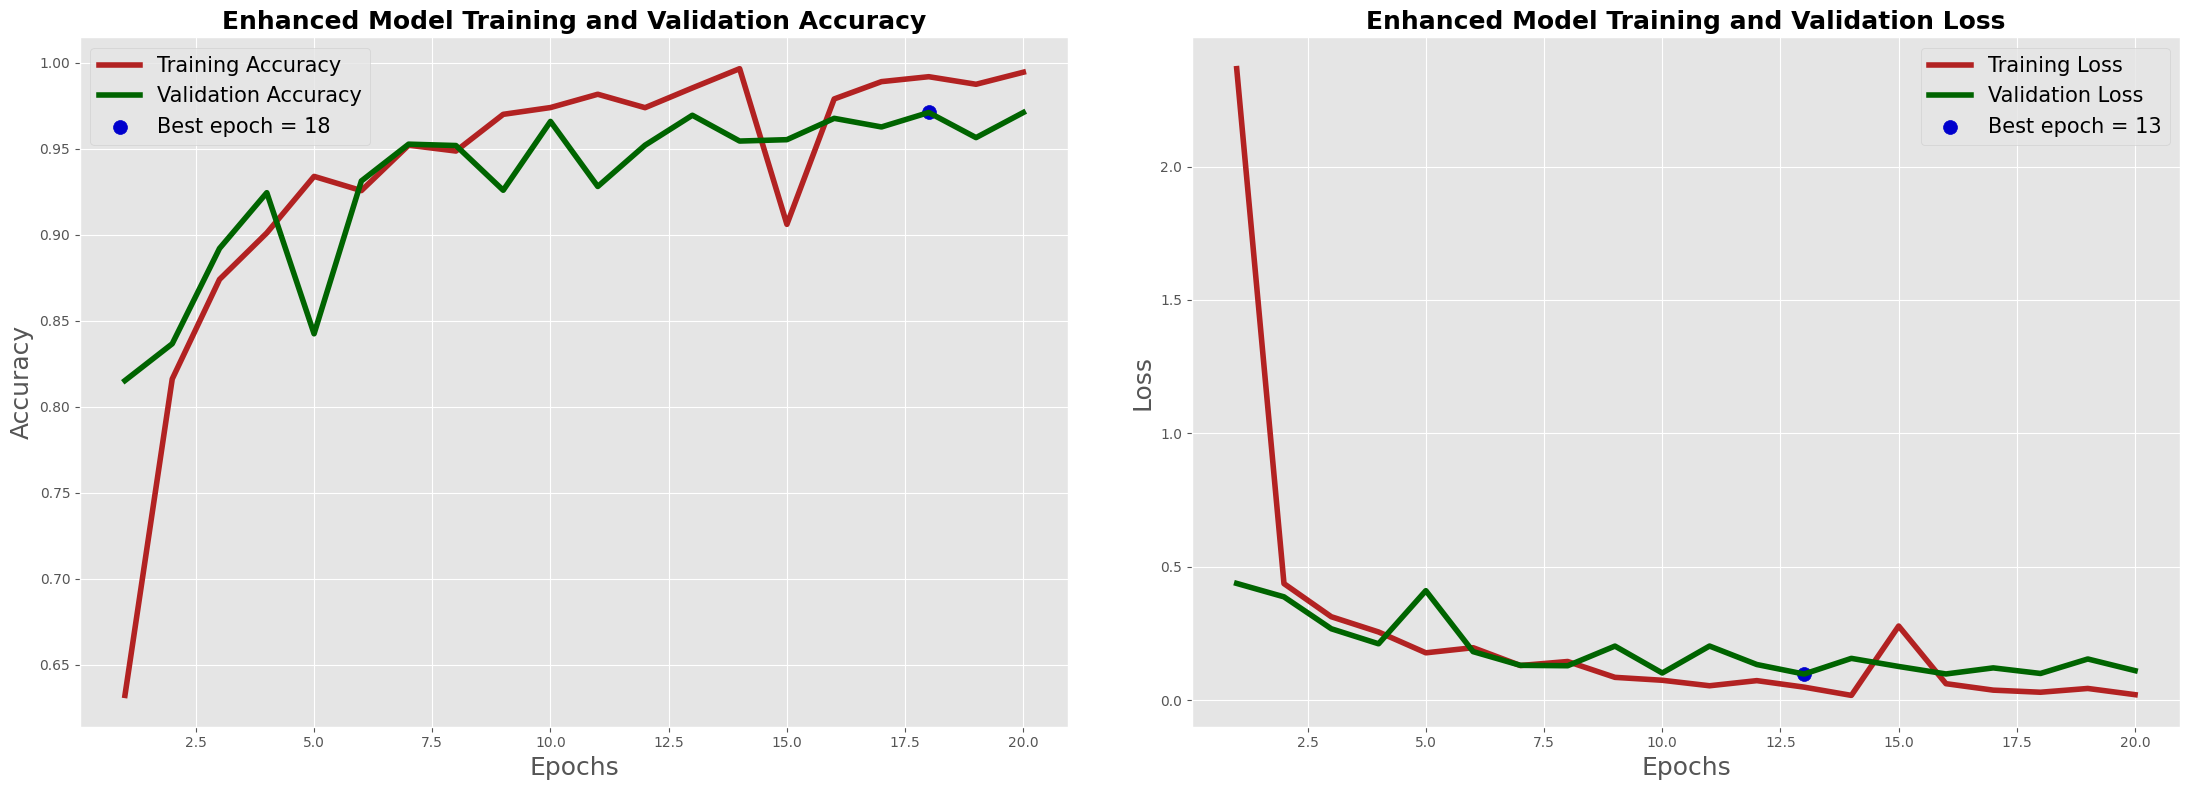

In [ ]:
plot_history(history, 'Enhanced Model')

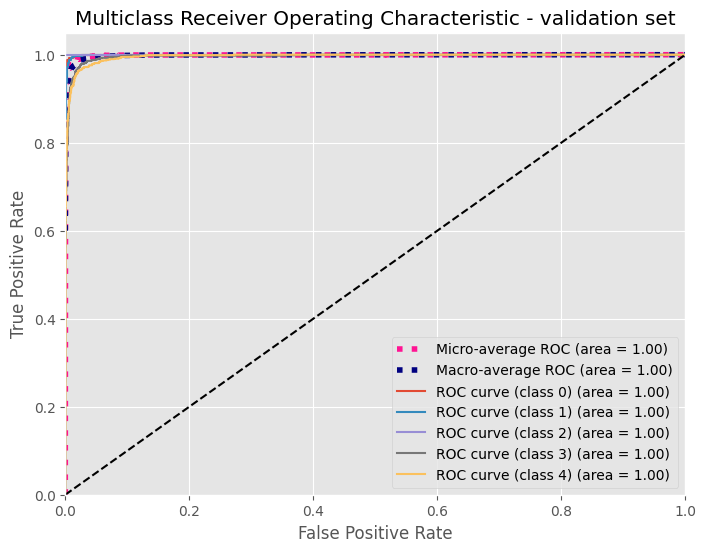

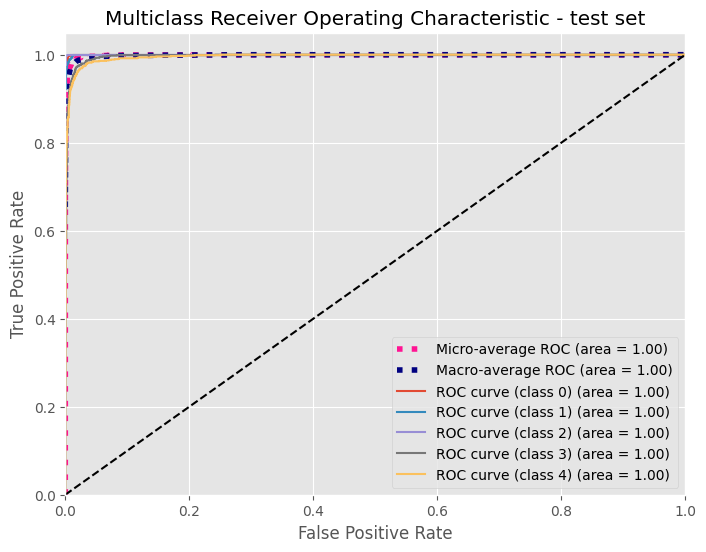

In [ ]:
plot_roc(model, X_val, y_val, 'validation')
plot_roc(model, X_test, y_test, 'test')

Classification report of the validation set:
                              precision    recall  f1-score   support

         Colon Benign Tissue       0.99      0.99      0.99      1000
        Colon adenocarcinoma       0.98      0.98      0.98      1000
          Lung Benign Tissue       1.00      1.00      1.00      1000
Lung Squamous Cell Carcinoma       0.96      0.94      0.95      1000
         Lung adenocarcinoma       0.93      0.95      0.94      1000

                    accuracy                           0.97      5000
                   macro avg       0.97      0.97      0.97      5000
                weighted avg       0.97      0.97      0.97      5000



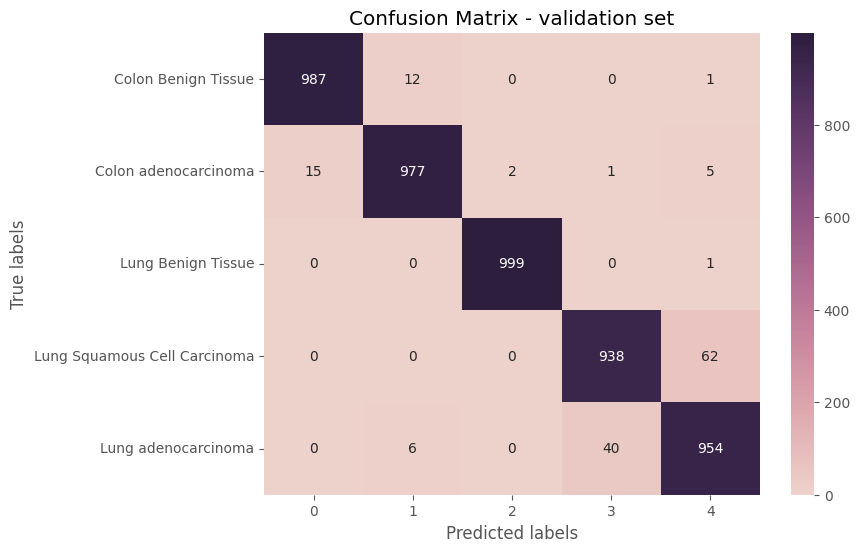


Classification report of the test set:
                              precision    recall  f1-score   support

         Colon Benign Tissue       0.99      0.99      0.99      1000
        Colon adenocarcinoma       0.98      0.99      0.98      1000
          Lung Benign Tissue       1.00      0.99      1.00      1000
Lung Squamous Cell Carcinoma       0.96      0.94      0.95      1000
         Lung adenocarcinoma       0.94      0.95      0.94      1000

                    accuracy                           0.97      5000
                   macro avg       0.97      0.97      0.97      5000
                weighted avg       0.97      0.97      0.97      5000



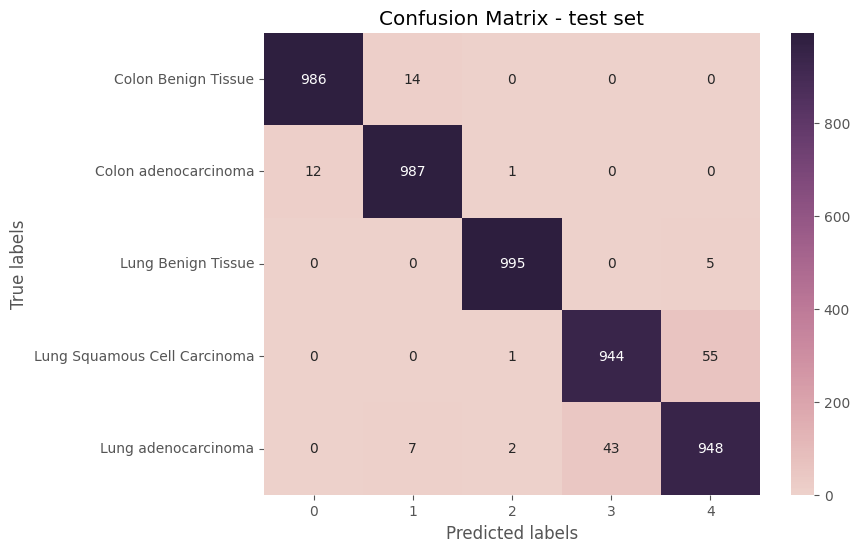

In [ ]:
plot_cm(model, X_val, y_val, 'validation')
plot_cm(model, X_test, y_test, 'test')

# Transfer Learning Model


### Compile the model

In [ ]:
# Enhanced VGG16 model
# Model tuning was performed in the transfer_learning_Jakob_Tjurlik.ipynb notebook.

# Load pre-trained VGG16 model
vgg_model = VGG16(include_top=False, input_shape=(120, 120, 3))

# Freeze the layers of the VGG16 model up to a certain point
for layer in vgg_model.layers:
    layer.trainable = False

# Add layers
model_transfer = models.Sequential()
model_transfer.add(vgg_model)
model_transfer.add(layers.Flatten())
model_transfer.add(layers.Dense(256, activation='relu'))
model_transfer.add(layers.Dropout(0.4))
model_transfer.add(layers.Dense(128, activation='relu'))
model_transfer.add(layers.Dense(n_classes, activation='softmax'))

# Compile
model_transfer.compile(optimizer='adam',
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])

# Display the model summary
model_transfer.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 4608)              0         
                                                                 
 dense_3 (Dense)             (None, 256)               1179904   
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 128)               32896     
                                                                 
 dense_5 (Dense)             (None, 5)                 645       
                                                                 
Total params: 15928133 (60.76 MB)
Trainable params: 12

### Model training and evaluation

In [ ]:
# Train the model
history = model_transfer.fit(X_train, y_train,
                                      epochs=20,
                                      batch_size=64,
                                      validation_data=(X_val, y_val),
                                      verbose=1)

# Evaluate the model on the test set
test_loss, test_accuracy = model_transfer.evaluate(X_test, y_test)

print("Baseline test loss:", test_loss)
print("Baseline test accuracy:", test_accuracy)

Epoch 1/20
235/235 [==============================] - 40s 141ms/step - loss: 0.8453 - accuracy: 0.8474 - val_loss: 0.1693 - val_accuracy: 0.9404
Epoch 2/20
235/235 [==============================] - 25s 108ms/step - loss: 0.2374 - accuracy: 0.9223 - val_loss: 0.1402 - val_accuracy: 0.9538
Epoch 3/20
235/235 [==============================] - 25s 108ms/step - loss: 0.1777 - accuracy: 0.9421 - val_loss: 0.1284 - val_accuracy: 0.9542
Epoch 4/20
235/235 [==============================] - 29s 125ms/step - loss: 0.1651 - accuracy: 0.9465 - val_loss: 0.1142 - val_accuracy: 0.9600
Epoch 5/20
235/235 [==============================] - 26s 109ms/step - loss: 0.1395 - accuracy: 0.9527 - val_loss: 0.1228 - val_accuracy: 0.9606
Epoch 6/20
235/235 [==============================] - 25s 108ms/step - loss: 0.1249 - accuracy: 0.9599 - val_loss: 0.1383 - val_accuracy: 0.9524
Epoch 7/20
235/235 [==============================] - 29s 125ms/step - loss: 0.1152 - accuracy: 0.9622 - val_loss: 0.0994 - val_ac

In [ ]:
# Save the results of the enhanced model
results = {'history': history.history, 'test_loss': test_loss,
           'test_accuracy': test_accuracy}

with open(file_dir + 'Results/transfer_model.pkl', 'wb') as file:
  pickle.dump(results, file)

### Visualization

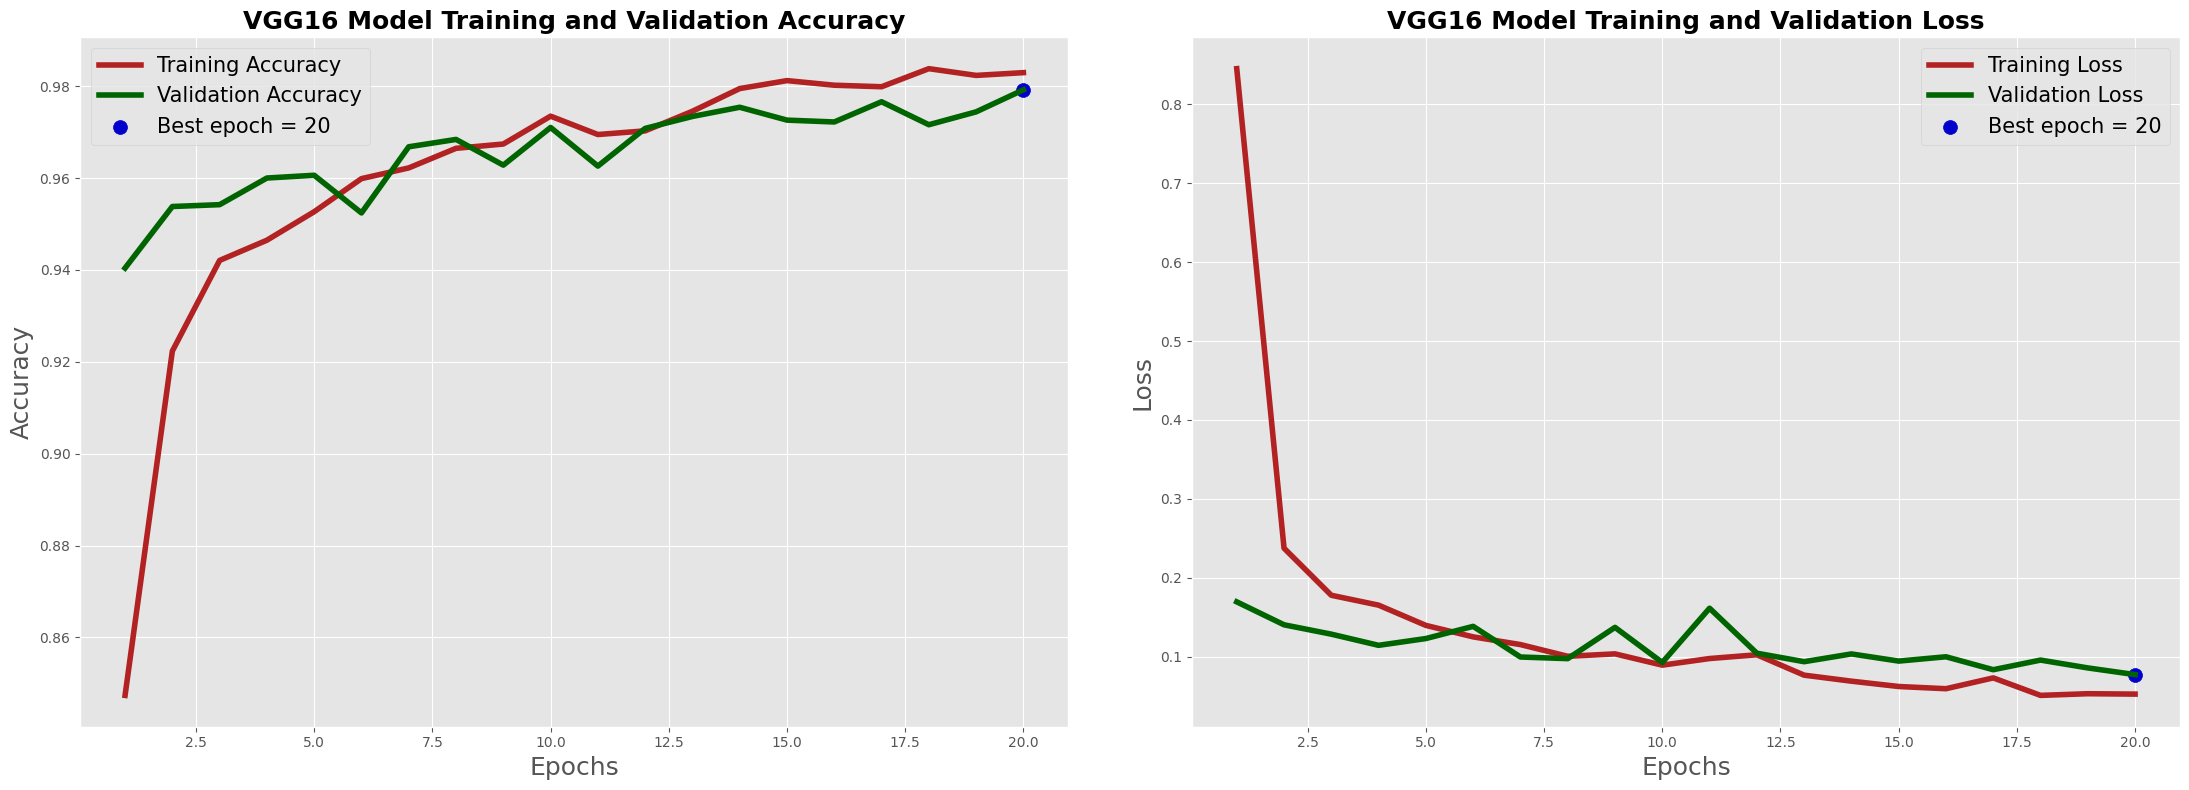

In [ ]:
plot_history(history, 'VGG16 Model')

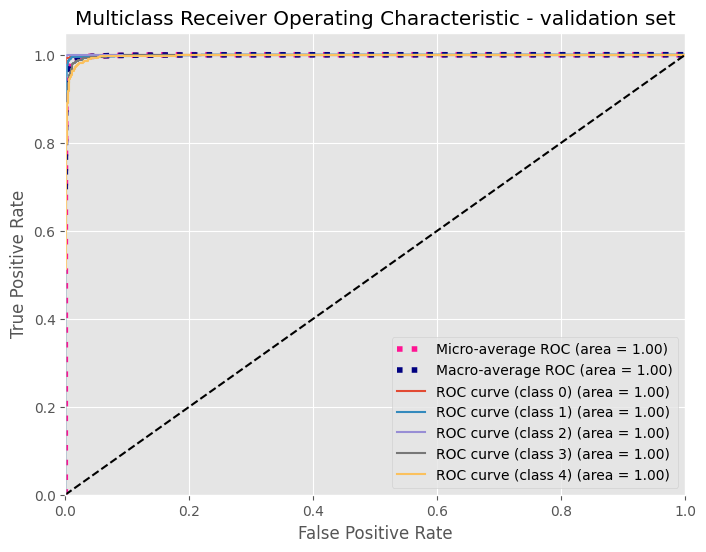

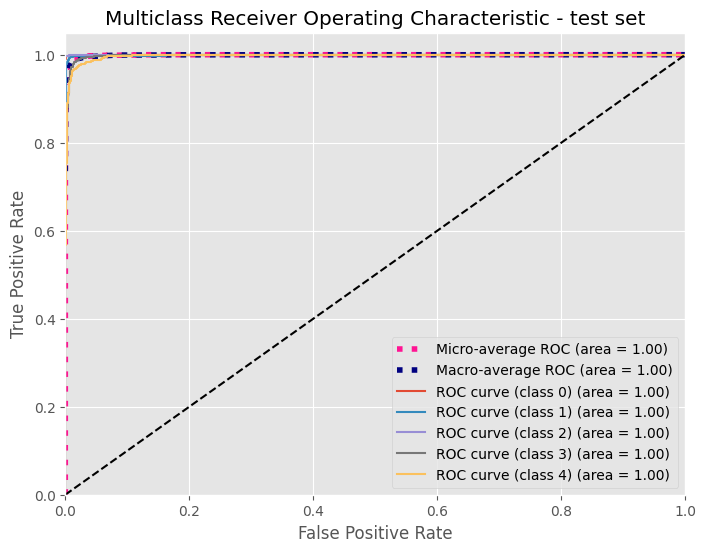

In [ ]:
plot_roc(model_transfer, X_val, y_val, 'validation')
plot_roc(model_transfer, X_test, y_test, 'test')

Classification report of the validation set:
                              precision    recall  f1-score   support

         Colon Benign Tissue       1.00      0.99      0.99      1000
        Colon adenocarcinoma       0.98      0.99      0.98      1000
          Lung Benign Tissue       1.00      1.00      1.00      1000
Lung Squamous Cell Carcinoma       0.96      0.98      0.97      1000
         Lung adenocarcinoma       0.97      0.95      0.96      1000

                    accuracy                           0.98      5000
                   macro avg       0.98      0.98      0.98      5000
                weighted avg       0.98      0.98      0.98      5000



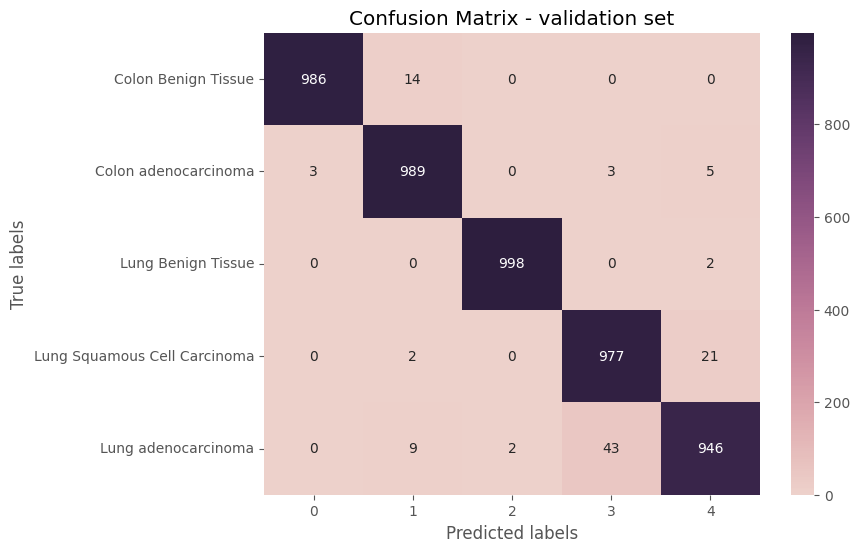


Classification report of the test set:
                              precision    recall  f1-score   support

         Colon Benign Tissue       1.00      0.99      0.99      1000
        Colon adenocarcinoma       0.98      0.99      0.98      1000
          Lung Benign Tissue       1.00      0.99      1.00      1000
Lung Squamous Cell Carcinoma       0.95      0.98      0.96      1000
         Lung adenocarcinoma       0.97      0.94      0.95      1000

                    accuracy                           0.98      5000
                   macro avg       0.98      0.98      0.98      5000
                weighted avg       0.98      0.98      0.98      5000



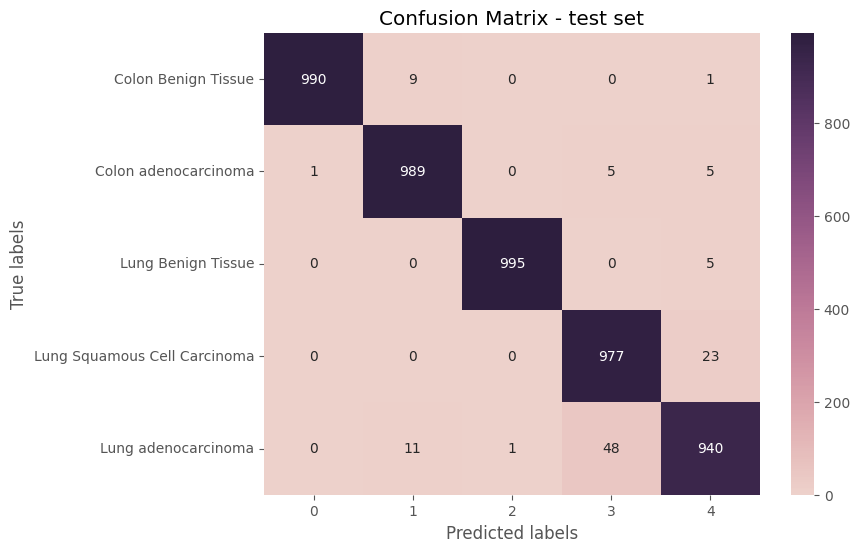

In [ ]:
plot_cm(model_transfer, X_val, y_val, 'validation')
plot_cm(model_transfer, X_test, y_test, 'test')